# Assignment 6: Apply NB

<ol>
    <li>Minimum data points need to be considered for people having 4GB RAM is <strong>50k</strong> and for 8GB RAM is <strong>100k</strong></li>
    <li>When you are using ramdomsearchcv or gridsearchcv you need not split the data into X_train,X_cv,X_test. As the above methods use kfold. The model will learn better if train data is more so splitting to X_train,X_test will suffice.</li>
    <li>If you are writing for loops to tune your model then you need split the data into X_train,X_cv,X_test.</li>
    <li>While splitting the data explore stratify parameter. </li>
    <li><strong>Apply Multinomial NB on these feature sets</strong></li>
        <ul>
            <li>Features that need to be considered</li> 
                <dl>
                  <dt>essay</dt>
                    <dd>while encoding essay, try to experiment with the max_features and n_grams parameter of vectorizers and see if it increases AUC score.</dd>
                  <dt>categorical features</dt>
                  <dd> - teacher_prefix</dd>
                  <dd> - project_grade_category</dd>
                  <dd> - school_state</dd>
                  <dd> - clean_categories</dd>
                  <dd> - clean_subcategories</dd>
                  <dt>numerical features</dt>
                  <dd> - price</dd>
                  <dd> - teacher_number_of_previously_posted_projects</dd>
                  <dd>while encoding the numerical features check <a href='https://imgur.com/ldZA1zg'>this</a> and <a href='https://ac-classroom-production.s3.amazonaws.com/public/COMMENT/Annotation_2020-05-21_225912_0lyZzN8.jpg'>this</a></dd>
                </dl>    
            <li><font color='red'>Set 1</font>: categorical, numerical features + preprocessed_eassay (BOW)</li>
            <li><font color='red'>Set 2</font>: categorical, numerical features + preprocessed_eassay (TFIDF)</li>
        </ul>
    <li><strong>The hyper paramter tuning(find best alpha:smoothing parameter)</strong>
        <ul>
    <li>Consider alpha values in range: 10^-5 to 10^2 like [0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]</li>
    <li>Explore class_prior = [0.5, 0.5] parameter which can be present in MultinomialNB function(go through <a href='https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html'>this</a> ) then check how results might change.
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>For hyper parameter tuning using k-fold cross validation(use GridsearchCV or RandomsearchCV)/simple cross validation data (write for loop to iterate over hyper parameter values)</li>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/hUv6aEy.jpg' width=300px><dd>-while plotting take log(alpha) on your X-axis so that it will be more readable</dd></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='https://imgur.com/q2P65L5.jpg' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
        <img src='https://i.imgur.com/IdN5Ctv.png' width=300px><dd>-plot the confusion matrix in heatmaps, while plotting the confusion matrix go through the <a href='https://stackoverflow.com/questions/61748441/how-to-fix-the-values-displayed-in-a-confusion-matrix-in-exponential-form-to-nor'>link </a>
</dd></li>
        </ul>
<li>find the top 20 features from either from feature <font color='red'>Set 1</font> or feature <font color='red'>Set 2</font> using values of `feature_log_prob_ ` parameter of `MultinomialNB` 
(https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) and print <strong>BOTH</strong> positive as well as negative corresponding feature names. <dd> - go through the <a href='https://imgur.com/mWvE7gj'>link </a> </dd>
    </li>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format
        <img src='http://i.imgur.com/YVpIGGE.jpg' width=400px>
    </li>
</ol>

# 2. Naive Bayes 

## 1.1 Loading Data

In [389]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

In [390]:
import pandas as pd
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [391]:
df = pd.read_csv('/content/gdrive/My Drive/preprocessed_data.csv')
df.head()

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03
2,ca,mrs,grades_prek_2,10,1,literacy_language,literacy,having class 24 students comes diverse learner...,329.00
3,ga,mrs,grades_prek_2,2,1,appliedlearning,earlydevelopment,i recently read article giving students choice...,481.04
4,wa,mrs,grades_3_5,2,1,literacy_language,literacy,my students crave challenge eat obstacles brea...,17.74


In [392]:
#dividing the target feature and other features into y and x to train the model
df.shape
y=df['project_is_approved'].values
x=df.drop(labels='project_is_approved',axis=1)
x.head(1)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05


<h2>1.2 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [393]:
#dividing the data into train and test datasets
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(x,y,test_size=0.33,stratify=y)

In [394]:
#print the the shape of test and train data
print("Train",X_train.shape,y_train.shape)
print("Test",X_test.shape,y_test.shape)

Train (73196, 8) (73196,)
Test (36052, 8) (36052,)


<h2>1.3 Make Data Model Ready: encoding eassay, and project_title</h2>

# **Set-1:BOW**

**Set 1 : Using Bag of words on feature essay**

In [395]:
featurelist_set1 = []

In [396]:
#fitting Countvectorizer on essay feature in X_train and for ngram_range=(1,2) cv_score is highest when we consider set of ngrams {(1,1),(1,2).......(3,3),(3,4).......(4,5),(5,5)}
vect = CountVectorizer(min_df=10,ngram_range=(1,2),max_features=5000)
vect.fit(X_train['essay'].values)

#appending features to the featurlist_set1 list to find top features
featurelist_set1.extend(vect.get_feature_names())

#converting text to vectors using bag of words
x_train_essay_bow=vect.transform(X_train['essay'].values)
x_test_essay_bow=vect.transform(X_test['essay'].values)
#shape of each x_train and x_test after converting to vectors
print(x_train_essay_bow.shape)
print(x_test_essay_bow.shape)
print(len(featurelist_set1))

(73196, 5000)
(36052, 5000)
5000


<h2>1.4 Make Data Model Ready: encoding numerical, categorical features</h2>

**Set 1 : Using Bag of words on feature school_state**

In [397]:
vect = CountVectorizer()
vect.fit(X_train['school_state'].values)
#appending features to the featurlist_set1 list to find top features
featurelist_set1.extend(vect.get_feature_names())
x_train_school_state_bow = vect.transform(X_train['school_state'].values) 
x_test_school_state_bow =  vect.transform(X_test['school_state'].values)

print("School_state after vectorizing")
print(x_train_school_state_bow.shape)
print(x_test_school_state_bow.shape)
print(len(featurelist_set1))

School_state after vectorizing
(73196, 51)
(36052, 51)
5051


**Set 1 : Using Bag of words on feature teacher_prefix**

In [398]:
vect = CountVectorizer()
vect.fit(X_train['teacher_prefix'].values)
#appending features to the featurlist_set1 list to find top features
featurelist_set1.extend(vect.get_feature_names())

x_train_teacher_prefix_bow = vect.transform(X_train['teacher_prefix'].values)
x_test_teacher_prefix_bow = vect.transform(X_test['teacher_prefix'].values)

print("teacher_prefix after vectorizing")
print(x_train_teacher_prefix_bow.shape)
print(x_test_teacher_prefix_bow.shape)
print(len(featurelist_set1))

teacher_prefix after vectorizing
(73196, 5)
(36052, 5)
5056


**Set 1 : Using Bag of words on feature project_grade_category**

In [399]:
vect = CountVectorizer()
vect.fit(X_train['project_grade_category'].values)
#appending features to the featurlist_set1 list to find top features
featurelist_set1.extend(vect.get_feature_names())

x_train_project_grade_category_bow = vect.transform(X_train['project_grade_category'].values)
x_test_project_grade_category_bow = vect.transform(X_test['project_grade_category'].values)

print("project_grade_category after vectorizing")
print(x_train_project_grade_category_bow.shape)
print(x_test_project_grade_category_bow.shape)
print(len(featurelist_set1))

project_grade_category after vectorizing
(73196, 4)
(36052, 4)
5060


**Set 1 : Using Bag of words on feature clean_categories**

In [400]:
vect = CountVectorizer()
vect.fit(X_train['clean_categories'].values)
#appending features to the featurlist_set1 list to find top features
featurelist_set1.extend(vect.get_feature_names())
x_train_clean_categories_bow = vect.transform(X_train['clean_categories'].values)
x_test_clean_categories_bow = vect.transform(X_test['clean_categories'].values)

print("clean_categories after vectorizing")
print(x_train_clean_categories_bow.shape)
print(x_test_clean_categories_bow.shape)
print(len(featurelist_set1))

clean_categories after vectorizing
(73196, 9)
(36052, 9)
5069


**Set 1 : Using Bag of words on feature clean_sub_categories**

In [401]:
vect = CountVectorizer()
vect.fit(X_train['clean_subcategories'].values)
#appending features to the featurlist_set1 list to find top features
featurelist_set1.extend(vect.get_feature_names())
x_train_clean_subcategories_bow = vect.transform(X_train['clean_subcategories'].values)
x_test_clean_subcategories_bow = vect.transform(X_test['clean_subcategories'].values)

print("clean_subcategories after vectorizing")
print(x_train_clean_subcategories_bow.shape)
print(x_test_clean_subcategories_bow.shape)
print(len(featurelist_set1))

clean_subcategories after vectorizing
(73196, 30)
(36052, 30)
5099


**Set 1 : Normilizing numerical feature price**



In [402]:
normalizer = Normalizer()
normalizer.fit(X_train['price'].values.reshape(-1,1))
#appending features to the featurlist_set1 list to find top features
featurelist_set1.append('price')
x_train_price_norm = normalizer.transform(X_train['price'].values.reshape(-1,1))
x_test_price_norm = normalizer.transform(X_test['price'].values.reshape(-1,1))

print("normalized price")
print(x_train_price_norm.shape)
print(x_test_price_norm.shape)
print(len(featurelist_set1))

normalized price
(73196, 1)
(36052, 1)
5100


**Set 1 : Normilizing numerical feature teacher_number_of_previously_posted_projects**



In [403]:
normalizer = Normalizer()
normalizer.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
x_train_previous_projects_norm = normalizer.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
x_test_previous_projects_norm = normalizer.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
#appending features to the featurlist_set1 list to find top features
featurelist_set1.append('Number of previous projects')
print("normalized teacher_number_of_previously_posted_projects")
print(x_train_previous_projects_norm.shape)
print(x_test_previous_projects_norm.shape)
print(len(featurelist_set1))

normalized teacher_number_of_previously_posted_projects
(73196, 1)
(36052, 1)
5101


In [404]:
#converting all the text features which are converted to vectors into X_tr(for training)and X_te(for testing)
from scipy.sparse import hstack
X_tr = hstack((x_train_essay_bow,x_train_school_state_bow,x_train_teacher_prefix_bow,x_train_project_grade_category_bow,x_train_clean_categories_bow,x_train_clean_subcategories_bow,x_train_price_norm,x_train_previous_projects_norm)).tocsr()
X_te = hstack((x_test_essay_bow,x_test_school_state_bow,x_test_teacher_prefix_bow,x_test_project_grade_category_bow,x_test_clean_categories_bow,x_test_clean_subcategories_bow,x_test_price_norm,x_test_previous_projects_norm)).tocsr()
print("Train and Test after vectorization")
print(X_tr.shape)
print(X_te.shape)

Train and Test after vectorization
(73196, 5101)
(36052, 5101)


## 1.5 Appling NB on different kind of featurization as mentioned in the instructions (BOW)

<br>Apply NB on different kind of featurization as mentioned in the instructions
<br> For Every model that you work on make sure you do the step 2 and step 3 of instrucations

**Hyper Parameter Tuning with GridSearch CV**



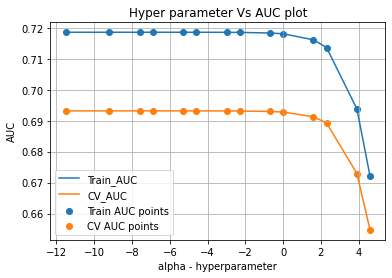

In [411]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score
from scipy.stats import randint

#calling constructor MultinomialNB
model = MultinomialNB()
#dictionary of hyperparameters
param = {'alpha':[0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100],'class_prior':[[0.5,0.5]]} 
# 
#calling GridSearchCV and passing hyperparametes and model
clf=GridSearchCV(model,param,cv=10,scoring='roc_auc',return_train_score=True)
clf.fit(X_tr,y_train)

#results of the gridsearch cv are stored as dataframe 'results'
results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_alpha'])

train_auc = results['mean_train_score']
train_auc_std = results['std_train_score']
cv_auc = results['mean_test_score']
cv_auc_std = results['std_test_score']
#As mentioned above taking log of alpha values for plotting
alpha = np.log(results['param_alpha'].astype(float))

#plot alpha-hyperparameter Vs AUC
plt.plot(alpha,train_auc,label='Train_AUC')
plt.plot(alpha,cv_auc,label='CV_AUC')

#plot for plotting each hyperparameter
plt.scatter(alpha, train_auc, label='Train AUC points')
plt.scatter(alpha, cv_auc, label='CV AUC points')
plt.legend()
plt.xlabel("alpha - hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot")
plt.grid()
plt.show()



In [416]:
#getting optimum hyperparameter into variable 'best_alpha'
best_alpha=clf.best_params_['alpha']
best_alpha

1e-05

In [417]:
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_class_prior,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.094737,0.004178,0.009664,0.000341,1e-05,"[0.5, 0.5]","{'alpha': 1e-05, 'class_prior': [0.5, 0.5]}",0.684449,0.700771,0.688003,0.682510,0.704514,0.705126,0.678803,0.689209,0.696541,0.701708,0.693163,0.009231,1,0.718682,0.719098,0.717909,0.718141,0.719314,0.717432,0.720157,0.718236,0.718507,0.718053,0.718553,0.000752
2,0.092285,0.002305,0.009616,0.000350,0.0001,"[0.5, 0.5]","{'alpha': 0.0001, 'class_prior': [0.5, 0.5]}",0.684449,0.700771,0.688003,0.682510,0.704513,0.705126,0.678803,0.689209,0.696541,0.701708,0.693163,0.009231,2,0.718682,0.719098,0.717909,0.718141,0.719314,0.717432,0.720156,0.718236,0.718507,0.718052,0.718553,0.000752
1,0.095642,0.004126,0.009957,0.000580,0.0005,"[0.5, 0.5]","{'alpha': 0.0005, 'class_prior': [0.5, 0.5]}",0.684449,0.700771,0.688003,0.682510,0.704513,0.705126,0.678802,0.689210,0.696541,0.701707,0.693163,0.009231,3,0.718682,0.719098,0.717909,0.718141,0.719313,0.717431,0.720156,0.718236,0.718507,0.718052,0.718553,0.000752
4,0.093229,0.003327,0.009449,0.000161,0.001,"[0.5, 0.5]","{'alpha': 0.001, 'class_prior': [0.5, 0.5]}",0.684449,0.700771,0.688003,0.682509,0.704513,0.705126,0.678801,0.689210,0.696540,0.701707,0.693163,0.009231,4,0.718682,0.719098,0.717909,0.718140,0.719313,0.717431,0.720156,0.718235,0.718506,0.718052,0.718552,0.000752
3,0.094378,0.004516,0.009496,0.000184,0.005,"[0.5, 0.5]","{'alpha': 0.005, 'class_prior': [0.5, 0.5]}",0.684449,0.700772,0.688001,0.682509,0.704512,0.705126,0.678799,0.689209,0.696537,0.701704,0.693162,0.009231,5,0.718679,0.719096,0.717907,0.718138,0.719311,0.717429,0.720154,0.718233,0.718504,0.718050,0.718550,0.000752
6,0.093842,0.003468,0.009594,0.000177,0.01,"[0.5, 0.5]","{'alpha': 0.01, 'class_prior': [0.5, 0.5]}",0.684447,0.700771,0.687999,0.682509,0.704507,0.705123,0.678796,0.689207,0.696535,0.701702,0.693160,0.009231,6,0.718677,0.719094,0.717905,0.718136,0.719309,0.717427,0.720151,0.718231,0.718502,0.718048,0.718548,0.000752
5,0.091842,0.001753,0.009472,0.000338,0.05,"[0.5, 0.5]","{'alpha': 0.05, 'class_prior': [0.5, 0.5]}",0.684436,0.700758,0.687984,0.682503,0.704489,0.705102,0.678782,0.689188,0.696523,0.701687,0.693145,0.009229,7,0.718657,0.719074,0.717885,0.718117,0.719289,0.717409,0.720131,0.718212,0.718483,0.718028,0.718528,0.000752
7,0.091571,0.001912,0.009494,0.000214,0.1,"[0.5, 0.5]","{'alpha': 0.1, 'class_prior': [0.5, 0.5]}",0.684419,0.700744,0.687961,0.682484,0.704470,0.705080,0.678760,0.689170,0.696504,0.701675,0.693127,0.009230,8,0.718633,0.719049,0.717861,0.718093,0.719264,0.717385,0.720106,0.718188,0.718459,0.718004,0.718504,0.000751
8,0.092604,0.002671,0.009573,0.000353,0.5,"[0.5, 0.5]","{'alpha': 0.5, 'class_prior': [0.5, 0.5]}",0.684285,0.700609,0.687769,0.682369,0.704335,0.704863,0.678612,0.689028,0.696326,0.701526,0.692972,0.009220,9,0.718437,0.718851,0.717666,0.717900,0.719065,0.717198,0.719906,0.717995,0.718266,0.717811,0.718309,0.000748
9,0.092084,0.002049,0.009525,0.000343,1,"[0.5, 0.5]","{'alpha': 1, 'class_prior': [0.5, 0.5]}",0.684126,0.700436,0.687528,0.682223,0.704154,0.704598,0.678414,0.688857,0.696117,0.701366,0.692782,0.009210,10,0.718192,0.718605,0.717426,0.717658,0.718817,0.716961,0.719657,0.717756,0.718020,0.717565,0.718066,0.000745


In [418]:
#training the model 
nb = MultinomialNB(alpha=best_alpha,class_prior=[0.5,0.5])
# 
nb.fit(X_tr,y_train)

y_train_pred = nb.predict(X_tr)
y_test_pred = nb.predict(X_te)

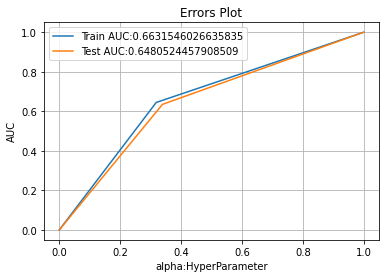

In [419]:
#storing fpr and tpr values of train and test data obtianed from AUC to plot roc_curve
train_fpr,train_tpr,train_thresholds = roc_curve(y_train,y_train_pred) 
test_fpr,test_tpr,test_thresholds = roc_curve(y_test,y_test_pred)

plt.plot(train_fpr,train_tpr,label="Train AUC:"+str(auc(train_fpr,train_tpr)))
plt.plot(test_fpr,test_tpr,label="Test AUC:"+str(auc(test_fpr,test_tpr)))

plt.legend()
plt.xlabel("alpha:HyperParameter")
plt.ylabel('AUC')
plt.title('Errors Plot')
plt.grid()
plt.show()

In [453]:
import seaborn as sns

Train Confusion Matrix


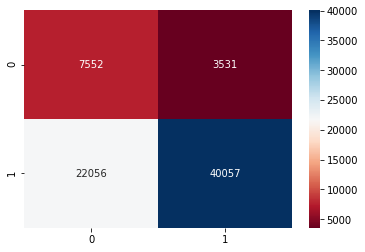

In [487]:
#confusion matix of train data
from sklearn.metrics import confusion_matrix
print("Train Confusion Matrix")
cm_train = confusion_matrix(y_train,y_train_pred)
sns.heatmap(cm_train,annot=True,fmt="d",cmap='RdBu')


In [488]:
TPR_train_bow=cm_train[1][1]/(cm_train[0][1]+cm_train[1][1]) #TP/P
TNR_train_bow=cm_train[0][0]/(cm_train[0][0]+cm_train[1][0]) #TN/N
FNR_train_bow=cm_train[0][1]/(cm_train[0][1]+cm_train[1][1]) #FN/P
FPR_train_bow=cm_train[1][0]/(cm_train[0][0]+cm_train[1][0])
print("(TPR_train_bow,TNR_train_bow,FNR_train_bow,FPR_train_bow):-",(TPR_train_bow,TNR_train_bow,FNR_train_bow,FPR_train_bow))

(TPR_train_bow,TNR_train_bow,FNR_train_bow,FPR_train_bow):- (0.9189914655409746, 0.25506619832477706, 0.08100853445902542, 0.7449338016752229)


Test Confusion Matrix


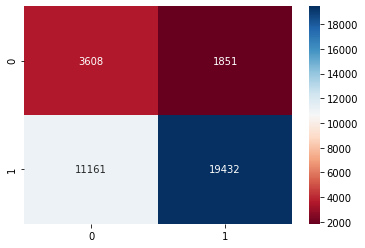

In [464]:
#confusion matrix of test data
print("Test Confusion Matrix")
cm_test=confusion_matrix(y_test,y_test_pred)
sns.heatmap(cm_test,annot=True,fmt="d",cmap='RdBu')

In [489]:
TPR_test_bow=cm_test[1][1]/(cm_test[0][1]+cm_test[1][1]) #TP/P
TNR_test_bow=cm_test[0][0]/(cm_test[0][0]+cm_test[1][0]) #TN/N
FNR_test_bow=cm_test[0][1]/(cm_test[0][1]+cm_test[1][1]) #FN/P
FPR_test_bow=cm_test[1][0]/(cm_test[0][0]+cm_test[1][0])
print("(TPR_test_bow,TNR_test_bow,FNR_test_bow,FPR_test_bow):-",(TPR_test_bow,TNR_test_bow,FNR_test_bow,FPR_test_bow))

(TPR_test_bow,TNR_test_bow,FNR_test_bow,FPR_test_bow):- (0.9130291782173566, 0.24429548378360078, 0.08697082178264343, 0.7557045162163992)


In [422]:
bow_auc_score = auc(test_fpr,test_tpr)

# Set-2: TFIDF

**Set 2: Using tf-idf on feature essay**











In [437]:
featurelist_set2=[]

In [438]:
#calling TfidfVectorizer constructor
tf_idf_vect = TfidfVectorizer(min_df=10,max_features=5000)
tf_idf_vect.fit(X_train['essay'].values)
featurelist_set2.extend(tf_idf_vect.get_feature_names())
x_train_essay_tfidf=tf_idf_vect.transform(X_train['essay'].values)
x_test_essay_tfidf=tf_idf_vect.transform(X_test['essay'].values)
print(x_train_essay_tfidf.shape)
print(x_test_essay_tfidf.shape)
print(len(featurelist_set2))

(73196, 5000)
(36052, 5000)
5000


In [439]:
a=['school_state','teacher_prefix','project_grade_category','clean_categories','clean_subcategories']
b=['price','Number of previous projects']
for i in a:
  vect = CountVectorizer()
  vect.fit(X_train[i].values)
  featurelist_set2.extend(vect.get_feature_names())
featurelist_set2.extend(b)
print(len(featurelist_set2))

5101


**Set 2: storing all the text converted vectors into a dataframe X_tr,X_te**



In [440]:
from scipy.sparse import hstack
X_tr_tfidf = hstack((x_train_essay_tfidf,x_train_school_state_bow,x_train_teacher_prefix_bow,x_train_project_grade_category_bow,x_train_clean_categories_bow,x_train_clean_subcategories_bow,x_train_price_norm,x_train_previous_projects_norm)).tocsr()
X_te_tfidf = hstack((x_test_essay_tfidf,x_test_school_state_bow,x_test_teacher_prefix_bow,x_test_project_grade_category_bow,x_test_clean_categories_bow,x_test_clean_subcategories_bow,x_test_price_norm,x_test_previous_projects_norm)).tocsr()
print("Train and Test after vectorization")
print(X_tr_tfidf.shape)
print(X_te_tfidf.shape)

Train and Test after vectorization
(73196, 5101)
(36052, 5101)


## 1.5 Appling NB on different kind of featurization as mentioned in the instructions (TFIDF)

<br>Apply NB on different kind of featurization as mentioned in the instructions
<br> For Every model that you work on make sure you do the step 2 and step 3 of instrucations

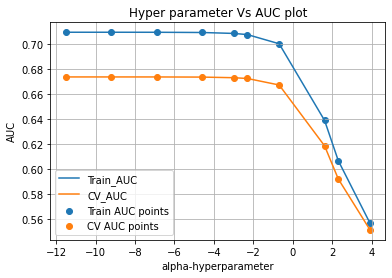

In [441]:
#finding best hyperparameters for MultinomialNB using RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score

#calling constructor MultinomialNB
model_tfidf = MultinomialNB()

#dictionary of hyperparameters
param_tfidf = {'alpha':[0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100],'class_prior':[[0.5,0.5]]} 
clf=RandomizedSearchCV(model_tfidf,param_tfidf,cv=10,scoring='roc_auc',return_train_score=True)
clf.fit(X_tr_tfidf,y_train)

#results of the randomizedsearch cv are stored as dataframe 'results'
results_tfidf = pd.DataFrame.from_dict(clf.cv_results_)
results_tfidf = results_tfidf.sort_values(['param_alpha'])
train_auc_tfidf = results_tfidf['mean_train_score']
train_auc_std_tfidf = results_tfidf['std_train_score']
cv_auc_tfidf = results_tfidf['mean_test_score']
cv_auc_std_tfidf = results_tfidf['std_test_score']
alpha_tfidf = np.log(results_tfidf['param_alpha'].astype(float))

#plot alpha-hyperparameter Vs AUC
plt.plot(alpha_tfidf,train_auc_tfidf,label='Train_AUC')
plt.plot(alpha_tfidf,cv_auc_tfidf,label='CV_AUC')

#plot for plotting each hyperparameter
plt.scatter(alpha_tfidf, train_auc_tfidf, label='Train AUC points')
plt.scatter(alpha_tfidf, cv_auc_tfidf, label='CV AUC points')

plt.legend()
plt.xlabel("alpha-hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot")
plt.grid()
plt.show()



In [442]:
best_alpha_tfidf=clf.best_params_['alpha']
best_alpha_tfidf

1e-05

In [443]:
results_tfidf

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_prior,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
2,0.077554,0.003403,0.008851,0.000320,"[0.5, 0.5]",1e-05,"{'class_prior': [0.5, 0.5], 'alpha': 1e-05}",0.664498,0.685087,0.669539,0.665654,0.682612,0.687828,0.659632,0.671220,0.673476,0.678814,0.673836,0.008975,1,0.709070,0.710628,0.709013,0.707568,0.710250,0.711068,0.710063,0.709937,0.709893,0.709608,0.709710,0.000932
4,0.075924,0.002633,0.008501,0.000137,"[0.5, 0.5]",0.0001,"{'class_prior': [0.5, 0.5], 'alpha': 0.0001}",0.664497,0.685084,0.669534,0.665668,0.682608,0.687826,0.659629,0.671214,0.673473,0.678812,0.673834,0.008973,2,0.709067,0.710625,0.709009,0.707562,0.710247,0.711065,0.710060,0.709934,0.709890,0.709604,0.709706,0.000932
9,0.077570,0.002011,0.008667,0.000257,"[0.5, 0.5]",0.001,"{'class_prior': [0.5, 0.5], 'alpha': 0.001}",0.664492,0.685073,0.669508,0.665728,0.682590,0.687816,0.659609,0.671187,0.673458,0.678803,0.673826,0.008968,3,0.709047,0.710605,0.708990,0.707536,0.710227,0.711045,0.710040,0.709915,0.709870,0.709584,0.709686,0.000934
5,0.075961,0.002160,0.008489,0.000151,"[0.5, 0.5]",0.01,"{'class_prior': [0.5, 0.5], 'alpha': 0.01}",0.664418,0.684957,0.669338,0.665776,0.682464,0.687710,0.659461,0.671039,0.673331,0.678690,0.673718,0.008959,4,0.708877,0.710434,0.708815,0.707347,0.710056,0.710871,0.709866,0.709746,0.709695,0.709406,0.709511,0.000938
7,0.075504,0.001236,0.009024,0.000796,"[0.5, 0.5]",0.05,"{'class_prior': [0.5, 0.5], 'alpha': 0.05}",0.664035,0.684436,0.668691,0.665454,0.681952,0.687258,0.658801,0.670529,0.672821,0.678226,0.673220,0.008970,5,0.708129,0.709698,0.708061,0.706578,0.709315,0.710122,0.709113,0.708999,0.708940,0.708639,0.708759,0.000944
0,0.080672,0.005327,0.008989,0.000740,"[0.5, 0.5]",0.1,"{'class_prior': [0.5, 0.5], 'alpha': 0.1}",0.663552,0.683780,0.667881,0.664936,0.681313,0.686660,0.657995,0.669930,0.672168,0.677650,0.672586,0.008987,6,0.707204,0.708777,0.707130,0.705637,0.708395,0.709196,0.708179,0.708077,0.708001,0.707689,0.707829,0.000949
8,0.076907,0.001713,0.008786,0.000305,"[0.5, 0.5]",0.5,"{'class_prior': [0.5, 0.5], 'alpha': 0.5}",0.659609,0.678381,0.661480,0.660386,0.676207,0.681613,0.651804,0.664931,0.666693,0.672633,0.667374,0.009068,7,0.699877,0.701439,0.699780,0.698273,0.701100,0.701851,0.700789,0.700760,0.700569,0.700199,0.700464,0.000957
6,0.078507,0.008535,0.008964,0.001102,"[0.5, 0.5]",5,"{'class_prior': [0.5, 0.5], 'alpha': 5}",0.620342,0.627262,0.606548,0.616106,0.628138,0.631282,0.601307,0.616162,0.616345,0.621631,0.618512,0.008947,8,0.638397,0.639158,0.639238,0.637825,0.638846,0.639350,0.639718,0.639139,0.638955,0.638293,0.638892,0.000538
1,0.077109,0.002434,0.008658,0.000377,"[0.5, 0.5]",10,"{'class_prior': [0.5, 0.5], 'alpha': 10}",0.597227,0.600528,0.578233,0.591633,0.602158,0.603352,0.575102,0.589659,0.588740,0.593117,0.591975,0.009081,9,0.606175,0.606378,0.607659,0.606171,0.605903,0.606334,0.607947,0.606809,0.606916,0.606192,0.606648,0.000648
3,0.078152,0.004955,0.008925,0.001082,"[0.5, 0.5]",50,"{'class_prior': [0.5, 0.5], 'alpha': 50}",0.555562,0.563389,0.536792,0.551896,0.562229,0.561423,0.536684,0.547773,0.544796,0.550000,0.551054,0.009309,10,0.556153,0.554991,0.558165,0.556470,0.555187,0.555131,0.558003,0.556700,0.557134,0.556406,0.556434,0.001069


In [444]:
#training the model 
nb_tfidf = MultinomialNB(alpha=best_alpha_tfidf,class_prior=[0.5,0.5])
nb_tfidf.fit(X_tr_tfidf,y_train)
y_train_pred_tfidf = nb_tfidf.predict(X_tr_tfidf)
y_test_pred_tfidf = nb_tfidf.predict(X_te_tfidf)

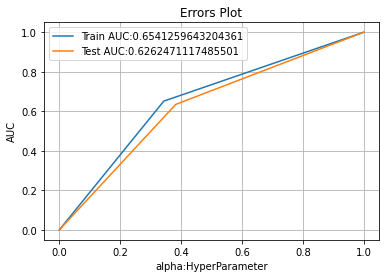

In [445]:
#storing fpr and tpr values of train and test data obtianed from AUC to plot roc_curve
train_fpr_tfidf,train_tpr_tfidf,train_thresholds_tfidf= roc_curve(y_train,y_train_pred_tfidf) 
test_fpr_tfidf,test_tpr_tfidf,test_thresholds_tfidf = roc_curve(y_test,y_test_pred_tfidf)

plt.plot(train_fpr_tfidf,train_tpr_tfidf,label="Train AUC:"+str(auc(train_fpr_tfidf,train_tpr_tfidf)))
plt.plot(test_fpr_tfidf,test_tpr_tfidf,label="Test AUC:"+str(auc(test_fpr_tfidf,test_tpr_tfidf)))

plt.legend()
plt.xlabel("alpha:HyperParameter")
plt.ylabel('AUC')
plt.title('Errors Plot')
plt.grid()
plt.show()

Train Confusion Matrix


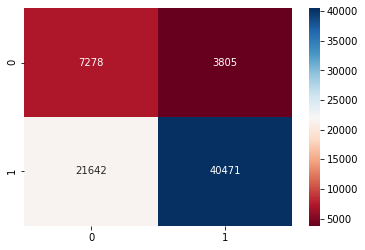

In [482]:
#confusion matrix of train data
from sklearn.metrics import confusion_matrix
print("Train Confusion Matrix")
cm_train_tfidf=confusion_matrix(y_train,y_train_pred_tfidf)
sns.heatmap(cm_train_tfidf,annot=True,fmt="d",cmap='RdBu')

In [483]:
TPR_train_tfidf=cm_train_tfidf[1][1]/(cm_train_tfidf[0][1]+cm_train_tfidf[1][1]) #TP/P
TNR_train_tfidf=cm_train_tfidf[0][0]/(cm_train_tfidf[0][0]+cm_train_tfidf[1][0]) #TN/N
FNR_train_tfidf=cm_train_tfidf[0][1]/(cm_train_tfidf[0][1]+cm_train_tfidf[1][1]) #FN/P
FPR_train_tfidf=cm_train_tfidf[1][0]/(cm_train_tfidf[0][0]+cm_train_tfidf[1][0])
print("(TPR_train_tfidf,TNR_train_tfidf,FNR_train_tfidf,FPR_train_tfidf):-",(TPR_train_tfidf,TNR_train_tfidf,FNR_train_tfidf,FPR_train_tfidf))

(TPR_train_tfidf,TNR_train_tfidf,FNR_train_tfidf,FPR_train_tfidf):- (0.9140617942000181, 0.2516597510373444, 0.08593820579998193, 0.7483402489626556)


Test Confusion Matrix


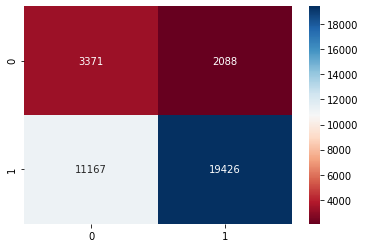

In [484]:
#confusion matrix of test data
print("Test Confusion Matrix")
cm_test_tfidf=confusion_matrix(y_test,y_test_pred_tfidf)
sns.heatmap(cm_test_tfidf,annot=True,fmt="d",cmap='RdBu')

In [485]:
TPR_test_tfidf=cm_test_tfidf[1][1]/(cm_test_tfidf[0][1]+cm_test_tfidf[1][1]) #TP/P
TNR_test_tfidf=cm_test_tfidf[0][0]/(cm_test_tfidf[0][0]+cm_test_tfidf[1][0]) #TN/N
FNR_test_tfidf=cm_test_tfidf[0][1]/(cm_test_tfidf[0][1]+cm_test_tfidf[1][1]) #FN/P
FPR_test_tfidf=cm_test_tfidf[1][0]/(cm_test_tfidf[0][0]+cm_test_tfidf[1][0])
print("(TPR_test_tfidf,TNR_test_tfidf,FNR_test_tfidf,FPR_test_tfidf):-",(TPR_test_tfidf,TNR_test_tfidf,FNR_test_tfidf,FPR_test_tfidf))

(TPR_test_tfidf,TNR_test_tfidf,FNR_test_tfidf,FPR_test_tfidf):- (0.9029469182857675, 0.23187508598156556, 0.09705308171423259, 0.7681249140184344)


In [448]:
tfidf_auc_score = auc(test_fpr_tfidf,test_tpr_tfidf)

## 3. Summary

<br> as mentioned in the step 5 of instructions

In [449]:
#set 1 top features
#lists to store top20 features of positive and negative classes
top20_set1_positive,top20_set1_negative=[],[]

positive=np.argsort(nb.feature_log_prob_[1])
negative=np.argsort(nb.feature_log_prob_[0])

#reversing the arrays to get probabilities in descending order
positive = positive[::-1]
negative = negative[::-1]

for i in positive[:20]:
  top20_set1_positive.append(featurelist_set1[i])
for j in negative[:20]:
  top20_set1_negative.append(featurelist_set1[j])
print("Top 20 features of positive class:\n",top20_set1_positive)
print("Top 20 features of negative class:\n",top20_set1_negative)

Top 20 features of positive class
 ['students', 'school', 'my', 'learning', 'classroom', 'the', 'they', 'not', 'my students', 'learn', 'help', 'price', 'many', 'nannan', 'we', 'need', 'reading', 'work', 'use', 'Number of previous projects']
Top 20 features of negative class
 ['students', 'school', 'learning', 'my', 'classroom', 'not', 'learn', 'they', 'help', 'the', 'my students', 'price', 'nannan', 'many', 'we', 'need', 'work', 'come', 'Number of previous projects', 'love']


In [450]:
#set 2 top features
#lists to store top20 features of positive and negative classes
top20_set2_positive,top20_set2_negative=[],[]

positive_set2=np.argsort(nb_tfidf.feature_log_prob_[1])
negative_set2=np.argsort(nb_tfidf.feature_log_prob_[0])

#reversing the arrays to get probabilities in descending order
positive_set2 = positive_set2[::-1]
negative_set2 = negative_set2[::-1]

for i in positive_set2[:20]:
  top20_set2_positive.append(featurelist_set2[i])
for j in negative_set2[:20]:
  top20_set2_negative.append(featurelist_set2[j])
print("Top 20 features of positive class:\n",top20_set2_positive)
print("Top 20 features of negative class:\n",top20_set2_negative)

Top 20 features of positive class
 ['price', 'Number of previous projects', 'mrs', 'literacy_language', 'grades_prek_2', 'math_science', 'ms', 'grades_3_5', 'literacy', 'mathematics', 'literature_writing', 'grades_6_8', 'ca', 'students', 'health_sports', 'specialneeds', 'specialneeds', 'appliedlearning', 'grades_9_12', 'mr']
Top 20 features of negative class
 ['price', 'Number of previous projects', 'mrs', 'literacy_language', 'grades_prek_2', 'math_science', 'ms', 'grades_3_5', 'literacy', 'mathematics', 'literature_writing', 'grades_6_8', 'specialneeds', 'specialneeds', 'students', 'ca', 'health_sports', 'appliedlearning', 'appliedsciences', 'grades_9_12']


In [451]:
#reference for the below code https://stackoverflow.com/questions/9535954/printing-lists-as-tabular-data

from prettytable import PrettyTable

table = PrettyTable(['Vectorizer','Model','Hyper Parameter','AUC'])
table.add_row(['BOW','Naive Bayes',best_alpha,bow_auc_score])
table.add_row(['TFIDF','Naive Bayes',best_alpha_tfidf,tfidf_auc_score])
print(table)

+------------+-------------+-----------------+--------------------+
| Vectorizer |    Model    | Hyper Parameter |        AUC         |
+------------+-------------+-----------------+--------------------+
|    BOW     | Naive Bayes |      1e-05      | 0.6480524457908509 |
|   TFIDF    | Naive Bayes |      1e-05      | 0.6262471117485501 |
+------------+-------------+-----------------+--------------------+


**Observation:**

1.   The AUC score is better when the vectorization was done with BOW rather than TFIDF
2.   Numerical Features 'Price' and 'Number of previous projects' are top features of both the classes in set-2 whereas they are not in top 10 features for both the classes in the set-1
3.  In both the sets the TNR and FNR are low and high we can conclude that model classify points of negative class with less accuracy when compare it with positive class. 
   



